In [1]:
%matplotlib inline
from solveFull import linearSolve_krylov as linearSolve
import numpy as np, matplotlib.pyplot as plt
import pystokes

In [2]:
def rotation(vector,alpha, beta, gamma):
    rotmat = np.array([[np.cos(beta)*np.cos(gamma), np.sin(alpha)*np.sin(beta)*np.cos(gamma) 
                        - np.cos(alpha)*np.sin(gamma), np.cos(alpha)*np.sin(beta)*np.cos(gamma)
                        + np.sin(alpha)*np.sin(gamma)],
                       [np.cos(beta)*np.sin(gamma),
                        np.sin(alpha)*np.sin(beta)*np.sin(gamma) + np.cos(alpha)*np.cos(gamma),
                        np.cos(alpha)*np.sin(beta)*np.sin(gamma) - np.sin(alpha)*np.cos(gamma)],
                       [-np.sin(beta),
                        np.sin(alpha)*np.cos(beta),
                        np.cos(alpha)*np.cos(beta)]])
    return np.dot(rotmat, vector)

In [3]:
# particle radius, self-propulsion speed, number and fluid viscosity
b, Np, eta = 1.0, 2, 0.1

## squirmer
D0  = 1.0      
S0  = 3/50*D0    # beta = 1 (positive beta is a puller (negative V2s)) - not sure which sign!

In [4]:
## initialise 
#initial position
r = np.array([-1.5,1.5, 0.,0. , 0., 0.])

#initial orientation
p = np.array([0., 0., 0.,0., 1.,1.])

##rotate particles 50deg towards each other
p[::Np] = rotation(p[::Np], 0., 25*2*np.pi/360, 0.)
p[1::Np] = rotation(p[1::Np], 0., -25*2*np.pi/360, 0.)


# initial slip modes
S = np.zeros(9*Np)
D = np.zeros(3*Np)
for i in range(Np):
    ## S in order: xx, xy, xz, yx, yy, yz, zx, zy, zz
    S[i]       = S0*(3*p[i]*p[i] -1.)
    S[i + Np]  = S0*(3*p[i]*p[i+Np])
    S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
    S[i + 3*Np]= S0*(3*p[i+Np]*p[i])
    S[i + 4*Np]= S0*(3*p[i+Np]*p[i+Np]-1.)
    S[i + 5*Np]= S0*(3*p[i+Np]*p[i+2*Np]) 
    S[i + 6*Np]= S0*(3*p[i+2*Np]*p[i+Np])
    S[i + 7*Np]= S0*(3*p[i+2*Np]*p[i+Np])
    S[i + 8*Np]= S0*(3*p[i+2*Np]*p[i+2*Np] - 1.)
    
    D[i]       = D0*p[i]
    D[i+Np]    = D0*p[i+Np]
    D[i+2*Np]  = D0*p[i+2*Np]

In [5]:
def rhs(rp): ##change this to give polarisation directly
    """
    Function that gives rhs for equations dr/dt=v and dp/dt= o x p
    """
    
    #position and angle theta (relative to initial angle)
    r = rp[0:3*Np]; p = rp[3*Np:6*Np]
    
    ## make sure orientations remain unit length
    norm_p1 = np.dot(p[::Np],p[::Np])
    norm_p2 = np.dot(p[1::Np],p[1::Np])
    
    p[::Np] = p[::Np]/np.sqrt(norm_p1)
    p[1::Np] = p[1::Np]/np.sqrt(norm_p2)
    
    
    F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)
    
    for i in range(Np):          
        F[i]      = 0.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 0.0 
        
        T[i]      = 0.0
        T[i+Np]   = 0.0
        T[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
        
        S[i]       = S0*(3*p[i]*p[i] -1.)
        S[i + Np]  = S0*(3*p[i]*p[i+Np])
        S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
        S[i + 3*Np]= S0*(3*p[i+Np]*p[i])
        S[i + 4*Np]= S0*(3*p[i+Np]*p[i+Np]-1.)
        S[i + 5*Np]= S0*(3*p[i+Np]*p[i+2*Np]) 
        S[i + 6*Np]= S0*(3*p[i+2*Np]*p[i+Np])
        S[i + 7*Np]= S0*(3*p[i+2*Np]*p[i+Np])
        S[i + 8*Np]= S0*(3*p[i+2*Np]*p[i+2*Np] - 1.)
        
        D[i]       = D0*p[i]
        D[i+Np]    = D0*p[i+Np]
        D[i+2*Np]  = D0*p[i+2*Np]

    
    #update repulsive force at position r
    forces.lennardJones(F, r, lje=5.0, ljr=2.1*b)
    
    #update velocity and angular velocity at r, acted on by F and T, and with slip modes S an D
    ls.RBM(v, o, r, F, T, S, D)
    
    dpdt = np.zeros(3*Np)
    
    for i in range(Np):
        dpdt[i]      = o[i+Np]*p[i+2*Np] - o[i+2*Np]*p[i+Np]    
        dpdt[i+Np]   = o[i+2*Np]*p[i   ] - o[i     ]*p[i+2*Np]  
        dpdt[i+2*Np] = o[i     ]*p[i+Np] - o[i+Np  ]*p[i]
        

    
    #return velocity and angular velocity cross orientation as right-hand side
    return np.concatenate( (v,dpdt) )

In [20]:
def simulate(rth0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=100000, **kwargs):
    
    def dxdtEval(rth,t):
        return rhs(rth)
    
    if integrator=='BDF': ## weird handling for this method
        from scipy.integrate import BDF
        X = BDF(lambda t, xt: dxdtEval(xt,t), Ti, rth0, Tf)
        
    if integrator=='odeint':
        from scipy.integrate import odeint
        time_points=np.linspace(Ti, Tf, Npts+1);
        X = odeint(dxdtEval, rth0, time_points, mxstep=maxNumSteps, **kwargs)
        
    if integrator=='solve_ivp':
        from scipy.integrate import solve_ivp
        time_points=np.linspace(Ti, Tf, Npts+1)                                                          
        X = solve_ivp(lambda t, xt: dxdtEval(xt,t), [0,Tf], rth0, 
                         t_eval=None, **kwargs)
        
    return X

In [35]:
%%time
#initiallize system and forces
ls = linearSolve(b, Np, eta)
forces  = pystokes.forceFields.Forces(particles=Np)

#simulate the resulting system
rp0 = np.concatenate((r,p))
Tf = 500.
Npts = 10

X = simulate(rp0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=1000,
             method='BDF')
X.message

CPU times: user 4min 32s, sys: 99.8 ms, total: 4min 32s
Wall time: 4min 10s


'The solver successfully reached the end of the integration interval.'

In [36]:
pos = X.y.T[:,0:3*Np]
times = X.t

In [37]:
pos1 = pos[:,::Np]
pos2 = pos[:,1::Np]

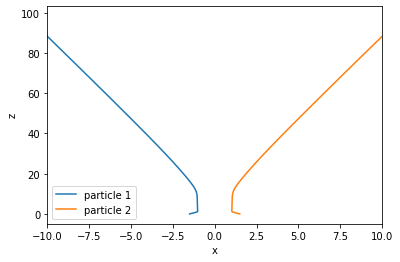

In [38]:
##x-y plot like in Ishikawa
plt.plot(pos1[:,0], pos1[:,2], label='particle 1')
plt.plot(pos2[:,0], pos2[:,2], label='particle 2')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim(-10,10)
plt.legend()
plt.show()

In [39]:
## minimum distance between the two particles
rmin = np.amin(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2))
rmax = np.amax(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2))
rmin, rmax

(2.0427881653971873, 22.45795736644454)

In [40]:
minIndex = np.where(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2)==rmin)
#minIndex[0][0] -= 18
xik,yik,zik = (pos1[minIndex,:]-pos2[minIndex,:])[0][0]
minIndex

(array([17]),)

In [41]:
xik,yik,zik ##they go out of plane? not anymore! 

(-2.0427881653971873, 0.0, -1.9984014443252818e-15)

In [42]:
##why does Krylov solver go so wrong? seems to introduce numerical error. 

## Try symmetry factor corrected matrix elements with a direct solver? 

In [43]:
print(pos1[:,0] + pos2[:,0])

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.22044605e-16
  4.44089210e-16  1.33226763e-15  1.77635684e-15  2.73114864e-14
  5.48450174e-14  3.59712260e-14  1.49880108e-13  3.89022148e-13
 -2.05169215e-13  4.10782519e-14  1.62758695e-12  4.60920191e-12
  9.12003806e-12  2.65427680e-11  4.95796737e-11  7.86481991e-11
  1.10829790e-10  2.01961337e-10  3.60982799e-10  5.64601699e-10
  8.20175039e-10  1.03164988e-09  1.20247123e-09  1.34599309e-09
  1.63989489e-09  1.88782323e-09  2.10886464e-09  2.44081999e-09
  2.80028534e-09  3.21089111e-09  3.66907216e-09  4.40534187e-09
  5.06901987e-09  5.64015146e-09  6.55628618e-09  7.26501348e-09]


In [44]:
orientations = X.y.T[:,3*Np:6*Np]
or1 = orientations[:,::Np]
or2 = orientations[:,1::Np]

In [45]:
or1[:,0] + or2[:,0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.11022302e-16,  1.66533454e-16,  5.55111512e-17,  2.77555756e-16,
       -8.86513085e-14, -5.45119505e-14, -2.28705943e-14,  1.03306252e-13,
        9.47020240e-14, -1.78745907e-14,  1.44800838e-13,  1.88571381e-13,
       -1.22624133e-13,  6.75924594e-13,  2.30826296e-12,  4.49635815e-12,
        7.02654601e-12,  1.37815731e-11,  1.95641003e-11,  2.35472475e-11,
        2.38708775e-11,  5.08457720e-11,  9.80984738e-11,  1.49064205e-10,
        1.75719911e-10,  1.62426156e-10,  1.35506384e-10,  1.13999254e-10,
        8.97641961e-11,  7.89850685e-11,  7.17910731e-11,  7.30385474e-11,
        8.26485547e-11,  9.40454381e-11,  1.02097414e-10,  9.60897195e-11,
        8.18056872e-11,  6.90771468e-11,  5.44935624e-11,  5.36815731e-11])

In [46]:
or1[:,2] - or2[:,2]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.22044605e-16, -1.11022302e-16,  1.11022302e-16, -2.22044605e-16,
       -2.39697151e-13, -1.60427227e-13, -8.26005930e-14,  2.59126054e-13,
        2.02393657e-13, -2.19491092e-13,  2.32369679e-13,  1.50990331e-13,
       -2.03170814e-12, -1.00630615e-12, -4.67736960e-13,  1.28563826e-13,
        5.67768055e-13,  4.42146320e-12,  1.43696166e-12,  3.94750899e-12,
        4.01711997e-12,  8.94784247e-12,  1.75525150e-11,  2.60863553e-11,
        2.79679613e-11,  2.43580711e-11,  1.97003525e-11,  1.64402936e-11,
        1.26793021e-11,  1.07486242e-11,  9.54247792e-12,  9.69468950e-12,
        1.07590603e-11,  1.20951027e-11,  1.30219169e-11,  1.20177202e-11,
        1.03638209e-11,  8.71991368e-12,  6.81188439e-12,  6.69864164e-12])

In [47]:
X.nfev

134